# News Article Semantic Similarity & Topic Retrieval Using Contrastive Learning

This notebook implements a complete contrastive learning pipeline for news article semantic similarity.


## 1. Environment Setup

Make sure you have installed all required packages:
```bash
pip install -r requirements.txt
```


## 2. Load Dataset


In [ ]:
from datasets import load_dataset
from src.data_loader import preprocess_dataset

# Load AG News dataset
dataset = load_dataset("ag_news")

# Inspect sample
print("Sample from train set:")
print(dataset['train'][0])
print(f"\nTrain size: {len(dataset['train'])}, Test size: {len(dataset['test'])}")


## 3. Preprocess Text


In [ ]:
# Preprocess dataset
dataset = preprocess_dataset(dataset)

# Check preprocessed sample
print("Preprocessed sample:")
print(dataset['train'][0])


## 4. Build Anchor-Positive-Negative Triplets


In [ ]:
from src.triplets import create_triplets_from_dataset

# Create triplets (limit for demo)
triplets = create_triplets_from_dataset(dataset['train'], max_triplets=2000)

print(f"Created {len(triplets)} triplets")
print("\nSample triplet:")
print(f"Anchor: {triplets[0][0][:100]}...")
print(f"Positive: {triplets[0][1][:100]}...")
print(f"Negative: {triplets[0][2][:100]}...")


## 5. Load Pre-Trained Encoder


In [ ]:
from sentence_transformers import SentenceTransformer

# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded: {model.get_sentence_embedding_dimension()} dimensions")


## 6. Baseline Evaluation


In [ ]:
from src.baseline import BaselineEvaluator
from src.data_loader import get_text_and_labels

# Get test samples (use 15000 for full evaluation)
baseline_samples = 15000
max_test_samples = len(dataset['test'])
baseline_samples = min(baseline_samples, max_test_samples)
print(f"Using {baseline_samples} samples for baseline evaluation (test set has {max_test_samples} samples)")

texts, labels = get_text_and_labels(dataset['test'], max_samples=baseline_samples)

# Evaluate baseline
baseline_evaluator = BaselineEvaluator(model_name='all-MiniLM-L6-v2')
baseline_embeddings = baseline_evaluator.encode(texts)

# Test similarity search
results = baseline_evaluator.compute_similarity(0, top_k=5)
print("\nTop 5 similar articles to query:")
for idx, score in results:
    print(f"  [{idx}] (score: {score:.4f}): {texts[idx][:80]}...")

# Visualize (use subset for visualization to avoid memory issues)
viz_samples = min(2000, len(texts))
print(f"\nVisualizing {viz_samples} samples (subset for memory efficiency)")
baseline_evaluator.visualize_embeddings(
    labels[:viz_samples] if len(labels) > viz_samples else labels,
    n_samples=viz_samples,
    save_path="../baseline_embeddings.png"
)


## 7. Prepare DataLoader for Contrastive Learning


In [ ]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

# Prepare training examples
train_examples = [InputExample(texts=[a, p, n]) for a, p, n in triplets[:2000]]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

print(f"Prepared {len(train_examples)} training examples")
print(f"Batch size: {train_dataloader.batch_size}")


## 8. Train Model with Contrastive Learning


In [ ]:
from src.training import ContrastiveTrainer

# Initialize trainer
trainer = ContrastiveTrainer(base_model_name='all-MiniLM-L6-v2')

# Prepare dataloader
train_dataloader = trainer.prepare_dataloader(triplets[:2000], batch_size=32)

# Train with triplet loss
num_epochs = 2
trainer.train(
    train_dataloader,
    loss_type='triplet',
    num_epochs=num_epochs,
    output_path='../models/news_contrastive_model',
    save_model=True
)

print("\nTraining complete!")


## 9. Evaluate Fine-Tuned Model



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Using existing texts and labels from baseline evaluation (500 samples)
Encoding texts for evaluation...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating on all queries...
Recall@1: 0.0036
Recall@5: 0.0138
Recall@10: 0.0255
MRR: 0.6121

Visualizing 500 samples (subset for memory efficiency)
Reducing dimensions with UMAP...


c:\Users\user\Desktop\Icog\contrastive_learning\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plot saved to ../finetuned_embeddings.png


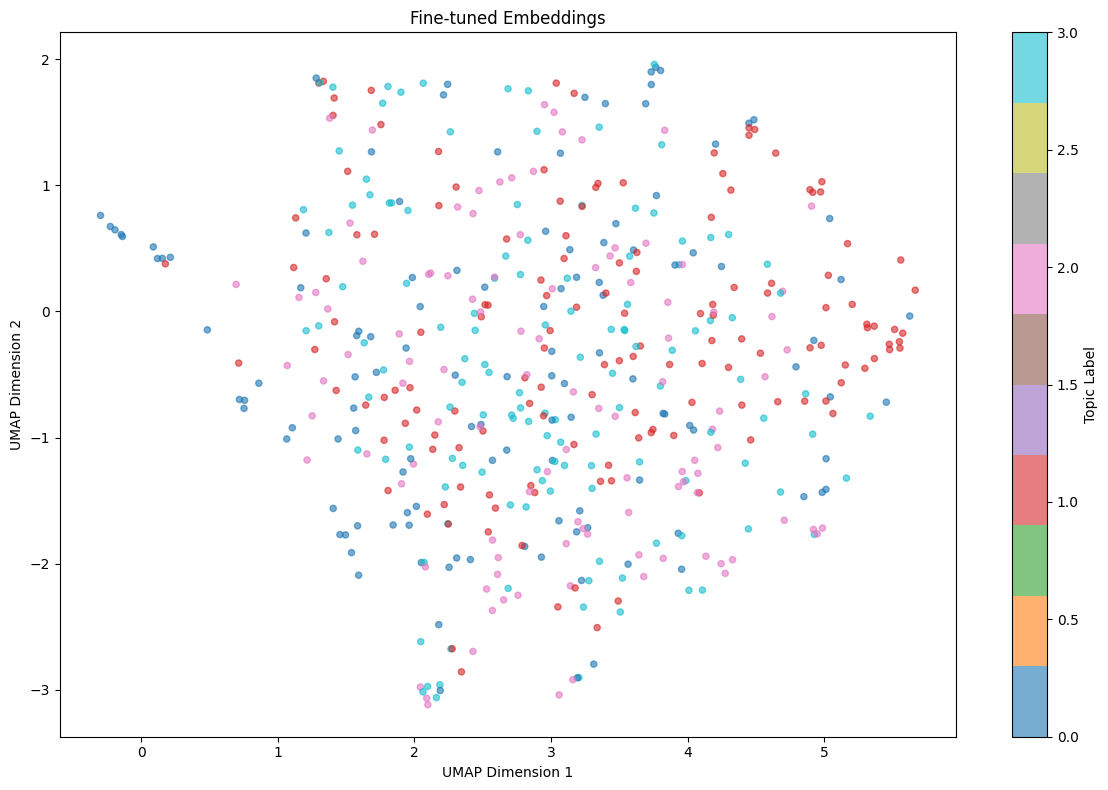


Using existing baseline_embeddings (500 samples)

Comparing fine-tuned model with baseline...
Fine-tuned embeddings: 500 samples
Baseline embeddings: 500 samples
Comparing with baseline...
Evaluating on all queries...
Recall@1: 0.0066
Recall@5: 0.0299
Recall@10: 0.0564
MRR: 0.8851
Evaluating on all queries...
Recall@1: 0.0036
Recall@5: 0.0138
Recall@10: 0.0255
MRR: 0.6121

Comparison Results:
Recall@1:
  Baseline:   0.0066
  Fine-tuned: 0.0036
  Improvement: -0.0029
Recall@5:
  Baseline:   0.0299
  Fine-tuned: 0.0138
  Improvement: -0.0161
Recall@10:
  Baseline:   0.0564
  Fine-tuned: 0.0255
  Improvement: -0.0309
MRR:
  Baseline:   0.8851
  Fine-tuned: 0.6121
  Improvement: -0.2730


In [3]:
%pip install -q tf-keras

# Ensure the project root (where `src` package lives) is on sys.path so local imports work
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# import the local evaluator (now that sys.path is adjusted)
from src.evaluation import Evaluator

# SentenceTransformer may already be imported in an earlier cell.
# Import it only if not present to avoid duplicate imports.
try:
    SentenceTransformer  # type: ignore
except NameError:
    from sentence_transformers import SentenceTransformer

# Load fine-tuned model
finetuned_model = SentenceTransformer('../models/news_contrastive_model')

# IMPORTANT: Use the same texts and labels from baseline evaluation (15000 samples)
# If they don't exist, recreate them with the same number of samples
try:
    texts  # type: ignore
    labels  # type: ignore
    print(f"Using existing texts and labels from baseline evaluation ({len(texts)} samples)")
except NameError:
    print("Texts/labels not found. Recreating with 15000 samples to match baseline...")
    # If 'dataset' is already available, use it; otherwise, load it here.
    try:
        dataset  # type: ignore
    except NameError:
        # Load dataset only if not already present
        try:
            load_dataset  # type: ignore
        except NameError:
            from datasets import load_dataset
        dataset = load_dataset("ag_news")
        # Preprocess if the function is available; import only if needed
        try:
            preprocess_dataset  # type: ignore
        except NameError:
            try:
                from src.data_loader import preprocess_dataset
            except Exception:
                preprocess_dataset = None  # Fallback if import fails
        if preprocess_dataset is not None:
            dataset = preprocess_dataset(dataset)

    # Obtain texts and labels using 15000 samples to match baseline evaluation
    try:
        get_text_and_labels  # type: ignore
    except NameError:
        from src.data_loader import get_text_and_labels
    
    # Use same number of samples as baseline (15000)
    baseline_samples = 15000
    max_test_samples = len(dataset['test'])
    baseline_samples = min(baseline_samples, max_test_samples)
    print(f"Creating texts and labels with {baseline_samples} samples to match baseline")
    texts, labels = get_text_and_labels(dataset['test'], max_samples=baseline_samples)

# Evaluate
evaluator = Evaluator(finetuned_model, texts, labels)
results = evaluator.evaluate_all(k_values=[1, 5, 10])

# Visualize improved embeddings (use subset for visualization to avoid memory issues)
viz_samples = min(2000, len(texts))
print(f"\nVisualizing {viz_samples} samples (subset for memory efficiency)")
evaluator.visualize_embeddings(
    labels=labels[:viz_samples] if len(labels) > viz_samples else labels,
    n_samples=viz_samples,
    save_path="../finetuned_embeddings.png",
    title="Fine-tuned Embeddings"
)

# Ensure baseline_embeddings exists; if not, compute it using the baseline encoder
try:
    baseline_embeddings  # type: ignore
    print(f"\nUsing existing baseline_embeddings ({baseline_embeddings.shape[0]} samples)")
except NameError:
    print("\nBaseline embeddings not found. Computing baseline with same texts...")
    try:
        BaselineEvaluator  # type: ignore
    except NameError:
        from src.baseline import BaselineEvaluator
    # Use the same texts already prepared
    baseline_evaluator = BaselineEvaluator(model_name='all-MiniLM-L6-v2')
    baseline_embeddings = baseline_evaluator.encode(texts)
    print(f"Computed baseline_embeddings with {baseline_embeddings.shape[0]} samples")

# Compare with baseline (ensure same number of samples)
print(f"\nComparing fine-tuned model with baseline...")
print(f"Fine-tuned embeddings: {len(texts)} samples")
print(f"Baseline embeddings: {baseline_embeddings.shape[0]} samples")
if baseline_embeddings.shape[0] != len(texts):
    print(f"[WARNING] Sample count mismatch! Using first {min(baseline_embeddings.shape[0], len(texts))} samples for comparison")
    min_samples = min(baseline_embeddings.shape[0], len(texts))
    baseline_embeddings = baseline_embeddings[:min_samples]
    texts = texts[:min_samples]
    labels = labels[:min_samples]
    # Recreate evaluator with matched samples
    evaluator = Evaluator(finetuned_model, texts, labels)

comparison = evaluator.compare_with_baseline(baseline_embeddings, k_values=[1, 5, 10])


## 10. Hard Negative Mining (Optional)


In [4]:
from src.hard_negatives import HardNegativeMiner
from src.data_loader import get_text_and_labels

# Get corpus for hard negative mining
corpus_texts, _ = get_text_and_labels(dataset['train'], max_samples=1000)

# Build BM25 index
miner = HardNegativeMiner()
miner.build_bm25_index(corpus_texts)

# Mine hard negatives
query = "breaking news in politics"
hard_negatives = miner.mine_bm25_hard_negatives(query, n=5)

print(f"Hard negatives for '{query}':")
for idx in hard_negatives:
    print(f"  [{idx}]: {corpus_texts[idx][:80]}...")


Building BM25 index...
Indexed 1000 documents
Hard negatives for 'breaking news in politics':
  [90]: science, politics collide in election year (ap) ap - with more than 4,000 scient...
  [36]: google ipo: type in 'confusing,' 'secrecy' i've submitted my bid to buy shares o...
  [388]: blackberries play politics wireless devices slip past anti-gadget policies to op...
  [554]: science and president bush collide in election year with more than 4,000 scienti...
  [840]: ex-chess champion fischer to marry japanese woman tokyo (reuters) - in a bold ga...


## 11. Math Behind InfoNCE Loss

The InfoNCE loss is defined as:

$$\\mathcal{L}_{i} = - \\log \\frac{\\exp(\\text{sim}(x_i, x_i^+)/\\tau)}{\\sum_{j=0}^{N} \\exp(\\text{sim}(x_i, x_j)/\\tau)}$$

Where:
- $x_i$ is the anchor
- $x_i^+$ is the positive sample
- $\\tau$ is the temperature hyperparameter
- $\\text{sim}$ is the cosine similarity function

See `docs/loss_explanation.md` for detailed explanation.
